# 1D Simulator
This code is used to simulate 1D equations in order to create some data for ai training. 

The first part will be the reprodcution of the heat diffusion in 1D such as :
$$
\begin{equation}
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}
\end{equation}
$$

In [7]:
import glob, os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import random

## 1D Grid creation helper

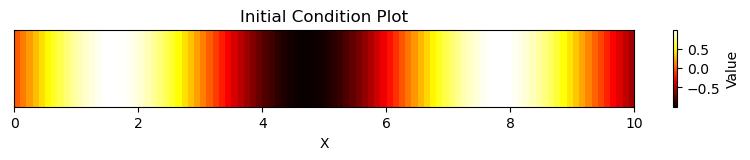

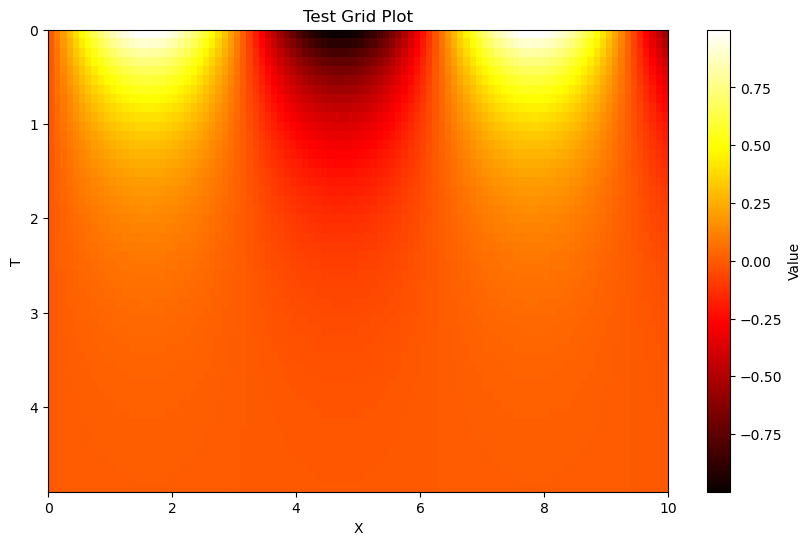

In [45]:
# Grid helper
class Grid1D:
    def __init__(self, nb_points_x, x_max, nb_points_t, dt):
        self.nb_points_x = nb_points_x
        self.x_max = x_max
        self.nb_points_t = nb_points_t
        self.dt = dt

        self.dx = x_max / (nb_points_x - 1)
        self.x = np.linspace(0, x_max, nb_points_x)
        self.t = np.linspace(0, dt * (nb_points_t - 1), nb_points_t)

        self.X, self.T = np.meshgrid(self.x, self.t)

    # --- Visualisation ---------------------------------------------------
    def plot(self, U, title="1D Simulation", xlabel="X", ylabel="T",
         label=None, cmap='hot', indicator=None):
        """
        Display the 2D matrix U (time × space) with an optional annotated colorbar.

        Args:
            U (ndarray): 2D matrix to display (T × X)
            title (str): plot title
            xlabel (str): label for the X axis
            ylabel (str): label for the Y axis
            label (str): label for the colorbar
            cmap (str): colormap
            indicator (str): text to append after each colorbar tick (e.g., '%', '°C', 'K')
        """
        plt.figure(figsize=(10, 6))
        im = plt.imshow(
            U,
            extent=[self.X.min(), self.X.max(), self.T.max(), self.T.min()],
            cmap=cmap,
            interpolation='nearest',
            aspect='auto',
            origin='upper'
        )
        cbar = plt.colorbar(im, label=label)

        # Si un indicateur est fourni, on le rajoute après chaque tick
        if indicator:
            ticks = cbar.get_ticks()
            cbar.set_ticklabels([f"{t:.0f}{indicator}" for t in ticks])

        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()

    def plot_initial_condition(self, U, title="X_initial", label=None, cmap='hot'):
        plt.figure(figsize=(10, 1))
        U0 = U[0, :]
        plt.imshow(
            U0[np.newaxis, :],
            extent=[self.X.min(), self.X.max(), 0, 1],
            cmap = cmap,
            interpolation='nearest',
            aspect='auto',
            origin='lower'
        )
        plt.colorbar(label=label)
        plt.title(title)
        plt.xlabel("X")
        plt.yticks([])
        plt.show()

    # --- Save & File Management -------------------------------
    @staticmethod
    def ensure_dir(path):
        if not os.path.exists(path):
            os.makedirs(path, exist_ok=True)

    def save_npz(self, path, U, alpha=None, tag=""):
        """
        Save the simulation to a compressed .npz file.
        Includes grid metadata and optionally α and a tag.
        """
        meta = dict(
            U=U.astype(np.float32),
            x=self.x.astype(np.float32),
            t=self.t.astype(np.float32),
            dx=np.float32(self.dx),
            dt=np.float32(self.dt),
        )
        if alpha is not None:
            meta["alpha"] = np.float32(alpha)
        if tag:
            meta["tag"] = np.str_(tag)

        # Assure que le dossier existe
        folder = os.path.dirname(path)
        if folder:
            self.ensure_dir(folder)

        np.savez_compressed(path, **meta)

    def generate_npz(self, U, filename="grid1d_data.npz"):
        self.save_npz(filename, U)


# Test the Grid1D class
grid = Grid1D(nb_points_x=100, x_max=10, nb_points_t=50, dt=0.1)
grid.plot_initial_condition(np.sin(grid.X), title="Initial Condition Plot", label="Value")
grid.plot(np.sin(grid.X) * np.exp(-1 * grid.T), title="Test Grid Plot", label="Value")



### Numerical scheme of the thermal simulator (ThermalDiffusion1D) using Torch

Continuous equation (1D diffusion / heat):
$$
\partial_t u(x,t) = \alpha\,\partial_{xx} u(x,t).
$$

Spatial discretization (uniform grid, spacing Δx) — centered second derivative:
$$
\partial_{xx} u(x_i,t^n) \approx \frac{u_{i+1}^n - 2u_i^n + u_{i-1}^n}{\Delta x^2}.
$$

Time discretization (explicit Euler, time step Δt):
$$
u_i^{\,n+1} = u_i^{\,n} + \alpha\,\Delta t\;\frac{u_{i+1}^n - 2u_i^n + u_{i-1}^n}{\Delta x^2}.
$$

This is exactly what the simulate() method implements:
U[n+1,:] = U[n,:] + alpha * d2Udx2 * dt
with d2Udx2 computed by the second-order finite difference in deriv2order().

Boundary treatment (current implementation):
- For i=0 and i=N-1 the code uses
  $$d^2u/dx^2\big|_{i=0}=\frac{u_1-2u_0+u_0}{\Delta x^2}=\frac{u_1-u_0}{\Delta x^2},$$
  and symmetrically on the right.
- This corresponds to using mirror ghost points (u_{-1}=u_0 and u_{N}=u_{N-1}), which enforces homogeneous Neumann boundary conditions (zero spatial derivative at boundaries).

Stability (CFL) reminder for the explicit scheme:
- Assume a Fourier mode u_i^n = g^n e^{i k x_i}; substitution in the scheme yields the amplification factor
$$
g(k) = 1 + 2\nu\big(\cos(k\Delta x)-1\big),\qquad \nu=\frac{\alpha\Delta t}{\Delta x^2}.
$$
- The most restrictive case is cos(kΔx) = −1, giving the constraint |g| ≤ 1 ⇒ ν ≤ 1/2.
- Hence the usual stability condition:
$$
\Delta t \le \frac{\Delta x^2}{2\alpha}.
$$

Short practical notes:
- The code already provides check_cfl(dx,dt,alpha); call it before running explicit simulations to avoid instability.
- If larger time steps are required, use an implicit scheme (Backward Euler or Crank–Nicolson), which is unconditionally stable.
- If Dirichlet boundary conditions are desired instead of Neumann, set boundary values explicitly or modify deriv2order() to include boundary values.

In [46]:
# Thermal Diffusion Simulator in 1D
class ThermalDiffusion1D:
    def __init__(self, grid, alpha, initial_condition, boundary_condition):
        self.grid = grid
        self.alpha = alpha
        self.initial_condition = initial_condition
        self.boundary_condition = boundary_condition

    def deriv2order(self, U):
        # U : 1D array of length nx
        nx = U.shape[0]
        d2Udx2 = np.zeros_like(U)
        if nx >= 3:
            d2Udx2[1:-1] = (U[2:] - 2 * U[1:-1] + U[:-2]) / (self.grid.dx ** 2)
        if nx >= 2:
            d2Udx2[0] = (U[1] - 2 * U[0] + U[0]) / (self.grid.dx ** 2)
            d2Udx2[-1] = (U[-1] - 2 * U[-1] + U[-2]) / (self.grid.dx ** 2)
        return d2Udx2

    def check_cfl(self):
        """Raise ValueError if explicit scheme is unstable for current grid/alpha."""
        dx = float(self.grid.dx)
        dt = float(self.grid.dt)
        alpha = float(self.alpha)
        limit = dx * dx / (2.0 * alpha + 1e-12)
        if dt > limit:
            raise ValueError(
                f"Unstable: dt={dt:.3e} > dx^2/(2α)={limit:.3e} (dx={dx:.3e}, α={alpha:.3e})"
            )

    def simulate(self):
        # Check CFL before starting explicit time-stepping
        self.check_cfl()

        nt = len(self.grid.t)
        nx = len(self.grid.x)
        U = np.zeros((nt, nx))
        U[0, :] = self.initial_condition(self.grid.x)

        for n in range(nt - 1):
            d2Udx2 = self.deriv2order(U[n, :])
            U[n + 1, :] = U[n, :] + self.alpha * d2Udx2 * self.grid.dt

        return U

### Exemple of usage for the creation of a sim of the 1D thermal equation

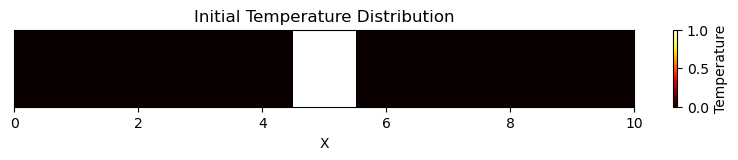

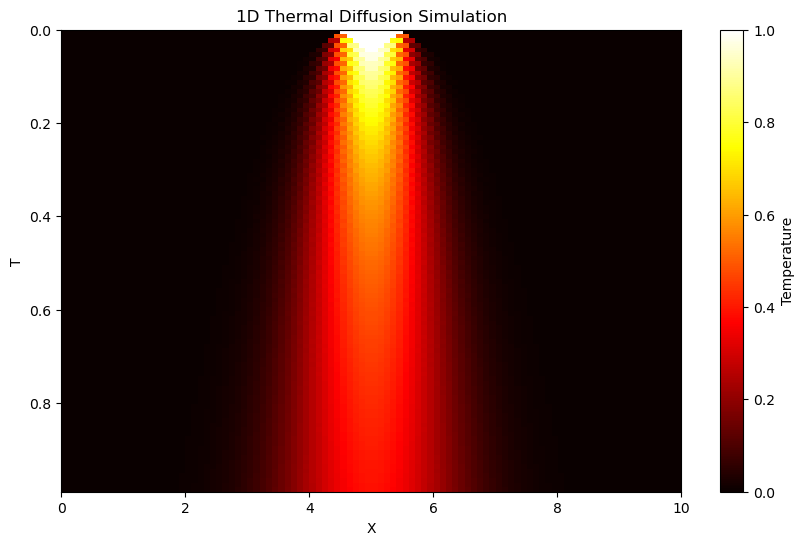

In [47]:
# Example usage
nbx = 100
nbt = 100
x_max = 10
dt = 0.01

initial_x = np.zeros_like(grid.x)
center_idx = len(grid.x) // 2
start_idx = center_idx - 5
end_idx = center_idx + 5
initial_x[start_idx:end_idx] = 1.0

alpha = 0.5

grid = Grid1D(nbx, x_max, nbt, dt)
simulator = ThermalDiffusion1D(
    grid,
    alpha,
    initial_condition=lambda x: initial_x,
    boundary_condition=lambda t: (0.0, 0.0)
)
U = simulator.simulate()
grid.plot_initial_condition(U, title="Initial Temperature Distribution", label="Temperature")
grid.plot(U, title="1D Thermal Diffusion Simulation", xlabel="X", ylabel="T", label="Temperature")


## Dataset Generation

### Initial conditions — choices and formulas

The different families of initial conditions are used to enrich the dataset (localized peaks, discontinuities, sinusoidal modes, smoothed random fields). For each type we note the mathematical form used:

- Gaussian (localized peak)
$$
u_0(x)=\exp\!\Big(-\frac{(x-\mu)^2}{2\sigma^2}\Big),
\quad
\mu\in[0.2x_{\max},\,0.8x_{\max}],\;
\sigma\in[0.05x_{\max},\,0.15x_{\max}].
$$

- Box (rectangular profile)
$$
u_0(x)=\mathbf{1}_{[a,b]}(x),\quad
a\sim\mathcal{U}(0.2x_{\max},0.6x_{\max}),\;
b\sim\mathcal{U}\big(a+0.05x_{\max},\,\min(a+0.3x_{\max},0.9x_{\max})\big).
$$

- Sinusoidal (oscillatory modes, centered amplitude)
$$
u_0(x)=\tfrac12\big(1+\sin(2\pi k\,x/x_{\max}+\varphi)\big),
\quad k\in\{1,\dots,4\},\;\varphi\sim\mathcal{U}(0,2\pi).
$$

- Smoothed random (rough field then filtered)  
Initial sample
$$
\tilde u(x)\sim\text{Unif}(0,1)
$$
then local smoothing by a discrete average (3-point filter):
$$
u_0(x)=\frac{\tilde u(x)+\tilde u(x+\Delta x)+\tilde u(x-\Delta x)}{3}.
$$

In [11]:
def sample_initial_condition(x, kind="gauss"):
    """
    Différents profils pour enrichir le dataset.
    """
    if kind == "gauss":
        mu = np.random.uniform(0.2*x.max(), 0.8*x.max())
        sigma = np.random.uniform(0.05*x.max(), 0.15*x.max())
        u0 = np.exp(-((x - mu)**2) / (2*sigma**2))
    elif kind == "box":
        a = np.random.uniform(0.2*x.max(), 0.6*x.max())
        b = np.random.uniform(a+0.05*x.max(), min(a+0.3*x.max(), 0.9*x.max()))
        u0 = np.zeros_like(x)
        u0[(x >= a) & (x <= b)] = 1.0
    elif kind == "sine":
        k = np.random.randint(1, 5)
        phase = np.random.uniform(0, 2*np.pi)
        u0 = 0.5*(1 + np.sin(2*np.pi*k*x/x.max() + phase))
    else:  # random lisse
        u0 = np.random.rand(len(x))
        u0 = (u0 + np.roll(u0,1) + np.roll(u0,-1))/3.0
    return u0

def make_initial_condition_fn(x, kind=None):
    if kind is None:
        kind = np.random.choice(["gauss","box","sine","smooth"])
    u0 = sample_initial_condition(x, kind)
    return lambda _x: u0

### Dataset Generation

In [12]:
# Dataset Generation Parameters
nbx, x_max = 128, 10.0
nbt, dt     = 128, 5e-3
alphas      = (0.02, 0.20) 
n_train     = 500
n_val       = 100
out_dir     = "generated_1d"

# Dataset sizes
n_train = 500
n_test  = 100

# It is also possible to randomize the grid size if needed
grid = Grid1D(nbx, x_max, nbt, dt)


def run_one_sim(grid, alpha, kind_ic=None):
    sim = ThermalDiffusion1D(
        grid=grid,
        alpha=alpha,
        initial_condition=make_initial_condition_fn(grid.x, kind_ic),
        boundary_condition=None  # (tu n’en as pas besoin ici)
    )
    U = sim.simulate()  # (nt, nx)
    return U

def data_generation(n, test=False):
    if test:
        out_dir = "generated_1d/test"
    else:
        out_dir = "generated_1d/train"

    for i in range(n):
        alpha = np.random.uniform(*alphas)
        kind  = np.random.choice(["gauss","box","sine","smooth"])
        U = run_one_sim(grid, alpha, kind_ic=kind)
        grid.save_npz(f"{out_dir}/sample_{i:04d}.npz", U, alpha=alpha, tag=kind)

# Generate training and test datasets
data_generation(n_train, test=False)
data_generation(n_test, test=True)

### Randomly load and visualize a sample from the test dataset

📂 Loaded file: sample_0099.npz


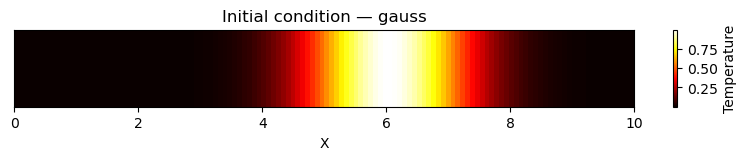

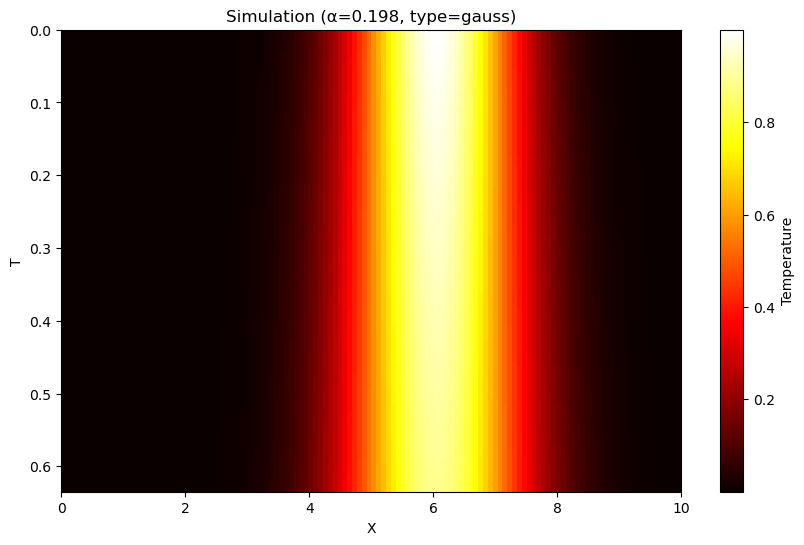

In [13]:
test_dir = "generated_1d/test"
files = [f for f in os.listdir(test_dir) if f.endswith(".npz")]

if not files:
    raise FileNotFoundError(f"No files found in {test_dir}. Run data_generation first.")

sample_file = random.choice(files)
sample_path = os.path.join(test_dir, sample_file)

print(f"📂 Loaded file: {sample_file}")

# --- Load contents ---
data = np.load(sample_path, allow_pickle=True)

U = data["U"]
x = data["x"]
t = data["t"]
dx = float(data["dx"])
dt = float(data["dt"])
alpha = float(data["alpha"]) if "alpha" in data else None
tag = data["tag"].item() if "tag" in data else "?"

grid_vis = Grid1D(
    nb_points_x=len(x),
    x_max=x.max(),
    nb_points_t=len(t),
    dt=dt
)

grid_vis.plot_initial_condition(U, title=f"Initial condition — {tag}", label="Temperature")
title = f"Simulation (α={alpha:.3f}, type={tag})" if alpha is not None else "Simulation"
grid_vis.plot(U, title=title, xlabel="X", ylabel="T", label="Temperature")


# NFTM creation

## Dataset Loading

In [14]:
class Heat1DDataset(Dataset):
    def __init__(self, folder):
        self.files = sorted(glob.glob(os.path.join(folder, "*.npz")))
        if not self.files:
            raise FileNotFoundError(f"Aucun .npz dans {folder} — génère d'abord les données.")
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        arr = np.load(self.files[idx], allow_pickle=True)
        U = arr["U"].astype(np.float32)      # (T, N)
        alpha = float(arr["alpha"]) if "alpha" in arr else None
        # tensors
        U = torch.from_numpy(U)              # (T, N)
        return {"U": U, "alpha": (torch.tensor(alpha, dtype=torch.float32) 
                                  if alpha is not None else torch.tensor(0.))}
        
train_set = Heat1DDataset("generated_1d/train")
test_set  = Heat1DDataset("generated_1d/test")

train_loader = DataLoader(train_set, batch_size=16, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_set,  batch_size=16, shuffle=False)

## Creation of the models

### NFTM1DBase — Base Class (Controller + Differentiable Memory Interface)

This class implements the basic structure of a Neural Turing Machine (NTM), as described in NFTM from DeepMind (2014, Section 3).

---

**NTM-inspired structure:**
- **Controller**: emits read/write commands at each time step \(t\).
- **Memory**: here a 1D vector \(U_t(x)\) (instead of a matrix \(M_t \in \mathbb{R}^{N\times M}\)).
- **Read Head**: selects a local window (left, center, right) around each cell.
- **Write Head**: applies a differentiable delta update at those positions.

---

In the original NTM, reading is a soft mixture:
$$
r_t = \sum_i w_t(i) M_t(i)
$$
where \(w_t(i)\) is a normalized attention weight (\(\sum_i w_t(i) = 1\)).

In our simplified 1D version, local reading is equivalent to location-based addressing (equations (7)–(9) of the paper), limited to three positions: left, center, right.

The `forward()` method corresponds to the temporal rollout of the controller, producing the full sequence:
$$
U_{t+1} = U_t + \Delta U_t, \quad \text{with} \quad \Delta U_t = \alpha \cdot f(U_t)
$$
where \(f(U_t)\) represents the differentiable read–write operation.


In [15]:
class NFTM1DBase(nn.Module):
    def __init__(self):
        super().__init__()

    @staticmethod
    def read_3tap(field):
        """
        field: (B, 1, N)
        retourne (center, lap) de taille (B, N) avec bords Neumann (réplication)
        lap = u_{i-1} - 2u_i + u_{i+1}
        """
        x = field.squeeze(1)                # (B, N)
        xpad = F.pad(x, (1,1), mode="replicate")
        left, center, right = xpad[:, :-2], x, xpad[:, 2:]
        lap = left - 2.0*center + right
        return center, lap

    @staticmethod
    def write_delta(field, delta):
        # field: (B,1,N), delta: (B,N)
        return field + delta.unsqueeze(1)

    def forward(self, f0, T):
        """
        Rollout for T time steps.
        f0: initial field tensor with shape (B, 1, N)
        """
        states = [f0]
        f = f0
        for _ in range(T-1):
            delta, _ = self.predict_next(f)
            f = self.write_delta(f, delta)
            states.append(f)
        return torch.stack(states, dim=1)  # (B,T,1,N)

### NFTM1DFixed — Fixed Diffusion Coefficient (Static Controller)

This subclass derives from `NFTM1DBase` and corresponds to an NTM with **fixed parameters**: the diffusion coefficient α is constant and not learnable.

The model applies a deterministic rule analogous to an explicit integration step:
$$
U_{t+1}(x) = U_t(x) + \alpha \, \Delta t \, \frac{\partial^2 U_t}{\partial x^2}
$$

- The read head retrieves local values via `read_3tap()`:
  $$
  \nabla^2 U(x_i) \approx U_{i-1} - 2U_i + U_{i+1}
  $$
- The write head then applies the update:
  $$
  \Delta U = \alpha \, (\text{laplacian})
  $$


In [16]:
class NFTM1DFixed(NFTM1DBase):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.alpha = float(alpha)

    def predict_next(self, field):
        center, lap = self.read_3tap(field)     # (B,N)
        delta = self.alpha * lap
        dbg = {"alpha": torch.full_like(center, self.alpha), "lap": lap}
        return delta, dbg



### NFTM1DLearnable — Learnable α and Stochastic Write Strength (Differentiable Program)

This version extends `NFTM1DBase` by making α and σ (write uncertainty) **learnable**.
It corresponds to an **NTM with an adaptive controller**, able to adjust the intensity
of its writes to better match the observed system's physics.

---

#### Reading
As in the original NTM (Eq. (2)):
$$
r_t = \sum_i w_t(i) M_t(i)
$$
here replaced by a local reading of the field:
$$
\text{lap}_t(i) = U_{i-1} - 2U_i + U_{i+1}
$$

#### Writing
Inspired by the erase–add decomposition (Eq. (3)–(4) of the paper), our write becomes:
$$
\Delta U_t(i) = \alpha \cdot \text{lap}_t(i)
$$
and the final update:
$$
U_{t+1}(i) = U_t(i) + \Delta U_t(i)
$$

---

#### Learnable parameters
- $ \alpha = e^{\log \alpha} $ clamped to an interval $ [\alpha_{\min}, \alpha_{\max}] $
- $ \sigma = e^{\log \sigma} $ controls the write variance (analogous to a differentiable "blurry write")

The heteroscedastic loss used is:
$$
\mathcal{L}_{\text{hetero}} =
\frac{1}{2}\frac{(\Delta U_{\text{pred}} - \alpha \, \text{lap})^2}{\sigma^2}
+ \frac{1}{2}\beta \log(\sigma^2)
$$

---
In summary:
$$
U_{t+1} = U_t + \alpha_\theta \, \nabla^2 U_t + \epsilon,\quad \epsilon \sim \mathcal{N}(0, \sigma^2)
$$
where $ \alpha_\theta $ and $ \sigma $ are optimized by gradient descent.


In [17]:
class NFTM1DLearnable(NFTM1DBase):
    """
    α global apprenable + σ (hétéroscédastique optionnelle)
    """
    def __init__(self, alpha_range=(1e-3, 1.0)):
        super().__init__()
        self.alpha_min, self.alpha_max = alpha_range
        init_alpha = (self.alpha_min*self.alpha_max)**0.5
        self.log_alpha = nn.Parameter(torch.log(torch.tensor(init_alpha)))
        self.log_sigma = nn.Parameter(torch.tensor(-2.0))  # σ ~ 0.135

    def current_alpha(self):
        return torch.clamp(torch.exp(self.log_alpha), self.alpha_min, self.alpha_max)

    def predict_next(self, field):
        center, lap = self.read_3tap(field)
        alpha = self.current_alpha()
        delta = alpha * lap
        dbg = {"alpha": alpha.detach().expand_as(center), "lap": lap}
        return delta, dbg

    def hetero_loss(self, delta_pred, gt_delta, lap, beta=1.0):
        alpha = self.current_alpha()
        sigma2 = torch.exp(2.0*self.log_sigma)
        mu = alpha * lap.detach()
        err = gt_delta - mu
        nll = 0.5*(err*err)/(sigma2+1e-8) + 0.5*beta*torch.log(sigma2+1e-8)
        # micro-priors soft
        prior = 1e-6*(self.log_alpha - torch.log(torch.tensor(0.1)))**2 + 1e-6*(self.log_sigma + 2.0)**2
        return nll.mean() + prior

## Training loop

### 📘 Phase A — Teacher-Forcing (Δu Supervision)

This first training step corresponds to the **local pre-training phase** described for our 1D NFTMs.  
The model learns to predict directly the instantaneous change of the field:
$$
\Delta U_t = U_{t+1} - U_t
$$

---

#### Objective, Approximate the local physical law:
$$
\Delta U_t \approx \alpha \, \nabla^2 U_t
$$
where:
- \( \alpha \) is the diffusion coefficient (fixed or learned),
- \( \nabla^2 U_t \) is the discrete Laplacian computed by the read head.

---

#### Training scheme
For each time step \( t \in [0, T-2] \):
1. Read the field: \( U_t \)  
2. Predict the delta: \( \widehat{\Delta U_t} = f_\theta(U_t) \)  
3. Compute the loss:

- MSE case (standard):
  $$
  \mathcal{L}_{\text{MSE}}
  = \frac{1}{N(T-1)} \sum_t \| \widehat{\Delta U_t} - \Delta U_t \|^2
  $$

- Heteroscedastic case (if σ is learned):
  $$
  \mathcal{L}_{\text{hetero}}
  = \frac{1}{2}\frac{(\widehat{\Delta U_t} - \alpha\,\nabla^2U_t)^2}{\sigma^2}
  + \frac{1}{2}\beta \log(\sigma^2)
  $$

---

#### NTM interpretation
In the context of the NTM paper:
- This phase corresponds to learning the short-term behavior of the **write heads**.  
- Each prediction ΔU_t is analogous to the NTM "add" step:
  $$
  M_t(i) = \tilde{M}_t(i) + w_t(i)\,a_t
  $$
  where $a_t \equiv \Delta U_t$ and $w_t$ are implicit (local 1D addressing).

In practice, Phase A lets the network learn the correct local update rule before attempting a full temporal rollout.


In [18]:
def train_phase_a(model, loader, opt, device, loss_mode="mse", steps_per_epoch=None):
    """
    Phase A: teacher-forcing sur Δu(t)
    - On parcourt les temps t=0..T-2 et on supervise le delta
    - Option: échantillonner un sous-ensemble de t pour aller vite
    """
    model.train()
    mse = nn.MSELoss()
    total_loss, batches = 0.0, 0
    for batch in loader:
        U = batch["U"].to(device)         # (B,T,N)
        B, T, N = U.shape
        if steps_per_epoch is None: t_indices = range(T-1)
        else:
            # sous-échantillonnage aléatoire de temps
            t_indices = np.random.choice(T-1, size=min(steps_per_epoch, T-1), replace=False)

        loss = 0.0
        for t in t_indices:
            field_t = U[:, t].unsqueeze(1)           # (B,1,N)
            delta_pred, dbg = model.predict_next(field_t)
            gt_delta = U[:, t+1] - U[:, t]           # (B,N)
            if loss_mode == "hetero" and hasattr(model, "hetero_loss"):
                loss = loss + model.hetero_loss(delta_pred, gt_delta, dbg["lap"])
            else:
                loss = loss + mse(delta_pred, gt_delta)
        loss = loss / max(1, len(list(t_indices)))
        opt.zero_grad(); loss.backward(); opt.step()
        total_loss += loss.item(); batches += 1
    return total_loss / max(1, batches)


@torch.no_grad()
def eval_phase_a(model, loader, device):
    model.eval()
    mse = nn.MSELoss(reduction="mean")
    total, batches = 0.0, 0
    for batch in loader:
        U = batch["U"].to(device)
        B, T, N = U.shape
        err = 0.0
        for t in range(T-1):
            field_t = U[:, t].unsqueeze(1)
            delta_pred, _ = model.predict_next(field_t)
            gt_delta = U[:, t+1] - U[:, t]
            err += mse(delta_pred, gt_delta)
        err = err / (T-1)
        total += err.item(); batches += 1
    return total / max(1, batches)

### Phase B — Rollout (Global Supervision)

The second training stage corresponds to the **full sequential learning**, where the NFTM is evaluated on the entire temporal trajectory.  
Instead of supervising each ΔU_t independently, we directly compare the predicted sequence with the reference sequence:
$$
U_{0:T}^{\text{pred}} \quad\text{vs.}\quad U_{0:T}^{\text{GT}}
$$

---

#### Propagation rule
At each step t:
$$
U_{t+1}^{\text{pred}} = U_t^{\text{pred}} + f_\theta(U_t^{\text{pred}})
$$
where \(f_\theta\) denotes the NFTM's internal mechanism (the differentiable read–write).

After the complete rollout:
$$
\mathcal{L}_{\text{rollout}}
= \frac{1}{NT} \sum_t \| U_t^{\text{pred}} - U_t^{\text{GT}} \|^2
$$

---

#### Performance metrics
In addition to the MSE loss, we often evaluate the **PSNR** (Peak Signal-to-Noise Ratio):
$$
\text{PSNR} = -10 \log_{10}
\left(
  \frac{1}{NT} \sum_t (U_t^{\text{pred}} - U_t^{\text{GT}})^2
\right)
$$

---

#### NTM interpretation
Within the NTM framework:
- This phase evaluates the **stability and generalization** of the learned program.
- The controller acts here as an **autonomous program** that traverses its memory without external supervision, equivalent to executing a learned algorithm recursively.

In other words, Phase B verifies that the read/write heads have learned a **coherent iterative rule**, not merely a local mapping between \(U_t\) and \(U_{t+1}\).


In [19]:
def train_phase_b(model, loader, opt, device):
    """
    Phase B: rollout complet supervisé sur u(t)
    """
    model.train()
    mse = nn.MSELoss()
    total_loss, batches = 0.0, 0
    for batch in loader:
        U = batch["U"].to(device)           # (B,T,N)
        B, T, N = U.shape
        f0 = U[:, 0].unsqueeze(1)           # (B,1,N)
        pred = model(f0, T).squeeze(2)      # (B,T,N)
        loss = mse(pred, U)
        opt.zero_grad(); loss.backward(); opt.step()
        total_loss += loss.item(); batches += 1
    return total_loss / max(1, batches)


@torch.no_grad()
def eval_phase_b(model, loader, device):
    model.eval()
    mse = nn.MSELoss()
    total, batches, psnrs = 0.0, 0, []
    for batch in loader:
        U = batch["U"].to(device)
        B, T, N = U.shape
        f0 = U[:, 0].unsqueeze(1)
        pred = model(f0, T).squeeze(2)
        loss = mse(pred, U)
        total += loss.item(); batches += 1
        psnr = -10.0*torch.log10(((pred-U)**2).mean()+1e-10).item()
        psnrs.append(psnr)
    return total / max(1,batches), float(np.mean(psnrs))


### Run training

### Complete training loop — Phase A → Phase B

The overall training of the NFTM follows a two-stage logic inspired by Graves et al. (2014):

1. **Phase A (teacher-forcing)**:
   - learning the local updates ΔU_t;
   - direct supervision of the read–write mechanism;
   - rapid stabilization of the heads' behavior.

2. **Phase B (rollout)**:
   - unconstrained sequential learning of the full dynamics;
   - optimization of temporal consistency for \(U_{t+1}=U_t+\alpha\nabla^2U_t\);
   - evaluation of generalization via PSNR and the global loss.

---

This protocol follows the principle of **differentiable program learning** from the NTM paper:
- Phase A corresponds to the **inference of the elementary subroutine**
  (like the *copy loop* or the *write routine*);
- Phase B corresponds to its **autonomous execution** over long sequences,
  demonstrating the controller's algorithmic generalization.

In short:
$$
\text{Phase A:}~~
\min_\theta
\sum_t
\|\widehat{\Delta U_t} - \Delta U_t\|^2,
\qquad
\text{Phase B:}~~
\min_\theta
\sum_t
\|U_t^{\text{pred}} - U_t^{\text{GT}}\|^2
$$

Combined, these two phases allow the 1D NFTM to learn to simulate thermal diffusion as a **differentiable Turing-like program**.


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Choisis l’un des deux modèles:
# model = NFTM1DFixed(alpha=0.2).to(device)                # α fixé <- peu efficace car alpha n'est pas fixe dans le dataset
model = NFTM1DLearnable(alpha_range=(1e-3, 1.0)).to(device) # α appris

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS_A = 10   # teacher-forcing Δu
EPOCHS_B = 10   # rollout u

for epoch in range(1, EPOCHS_A+1):
    tr = train_phase_a(model, train_loader, opt, device, loss_mode="mse", steps_per_epoch=8)
    va = eval_phase_a(model, test_loader, device)
    if epoch % 20 == 0:
        if isinstance(model, NFTM1DLearnable):
            print(f"[A] ep{epoch:03d}  trainΔ={tr:.5f}  valΔ={va:.5f}  alpha~{model.current_alpha().item():.4f}")
        else:
            print(f"[A] ep{epoch:03d}  trainΔ={tr:.5f}  valΔ={va:.5f}")

for epoch in range(1, EPOCHS_B+1):
    tr = train_phase_b(model, train_loader, opt, device)
    va, psnr = eval_phase_b(model, test_loader, device)
    if epoch % 25 == 0:
        if isinstance(model, NFTM1DLearnable):
            print(f"[B] ep{epoch:03d}  train={tr:.5f}  val={va:.5f}  PSNR={psnr:.2f}dB  alpha~{model.current_alpha().item():.4f}")
        else:
            print(f"[B] ep{epoch:03d}  train={tr:.5f}  val={va:.5f}  PSNR={psnr:.2f}dB")


## Visualization and Errors

### Load data

In [42]:
# --- Select a random file from the test set ---
test_dir = "generated_1d/test"
files = [f for f in os.listdir(test_dir) if f.endswith(".npz")]
assert files, "No test files found — generate the dataset first."
sample_path = os.path.join(test_dir, random.choice(files))
print(f"→ Selected sample: {sample_path}")

# --- Load simulation data ---
data = np.load(sample_path, allow_pickle=True)
U_np = data["U"].astype(np.float32)   # (T, N)
x = data["x"]; t = data["t"]
dt_vis = float(data["dt"])
alpha_gt = float(data["alpha"]) if "alpha" in data else None  # ground-truth α
tag = data["tag"].item() if "tag" in data else "?"

# --- Model rollout from t=0 ---
with torch.no_grad():
    U = torch.from_numpy(U_np).unsqueeze(0).to(device)  # (1, T, N)
    T, N = U.shape[1], U.shape[2]
    f0 = U[:, 0].unsqueeze(1)                           # (1, 1, N)
    pred = model(f0, T).squeeze(2)[0].cpu().numpy()     # (T, N)

    # Retrieve the predicted alpha coefficient from the model
    if hasattr(model, "current_alpha"):
        alpha_pred = float(model.current_alpha().item())   # for NFTM1DLearnable
    else:
        alpha_pred = getattr(model, "alpha", None)         # for NFTM1DFixed

→ Selected sample: generated_1d/test\sample_0091.npz


### Error measures

Let e_{i,t} = \hat u_{i,t} - u_{i,t} be the error at spatial point i and time t (N spatial points, T time steps).

- Mean Absolute Error (MAE), per time t:
\[
\mathrm{MAE}_t=\frac{1}{N}\sum_{i=1}^N |e_{i,t}|
\]

- RMSE (Root Mean Squared Error), per time t:
\[
\mathrm{RMSE}_t=\sqrt{\frac{1}{N}\sum_{i=1}^N e_{i,t}^2}
\]

- Global versions (over all times):
\[
\mathrm{MAE}=\frac{1}{NT}\sum_{t=1}^T\sum_{i=1}^N |e_{i,t}|
\qquad
\mathrm{RMSE}=\sqrt{\frac{1}{NT}\sum_{t=1}^T\sum_{i=1}^N e_{i,t}^2}
\]

- PSNR (in dB), with MSE = RMSE^2 and a small constant \(\varepsilon\) for stability:
\[
\mathrm{PSNR}=-10\log_{10}\big(\mathrm{MSE}+\varepsilon\big)
\]

Short remarks:
- MAE is more robust to outliers (same units as u).  
- RMSE penalizes large errors more (sensitive to outliers) and is appropriate when errors are Gaussian.  
- Always: \(\mathrm{RMSE} \ge \mathrm{MAE}\) (equality if all absolute errors are identical).

In [43]:
u_min, u_max = U_np.min(), U_np.max()
u_range = u_max - u_min if (u_max - u_min) != 0 else 1.0
error = np.abs(U_np - pred) / u_range * 100.0   # [%]
mae_time  = error.mean(axis=1)
rmse_time = np.sqrt((error**2).mean(axis=1))

### Plot

C:\Users\Samue\AppData\Local\Temp\ipykernel_34020\3444858711.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar2.set_ticklabels([f"{t:.0f}%" for t in ticks])  # entiers sinon


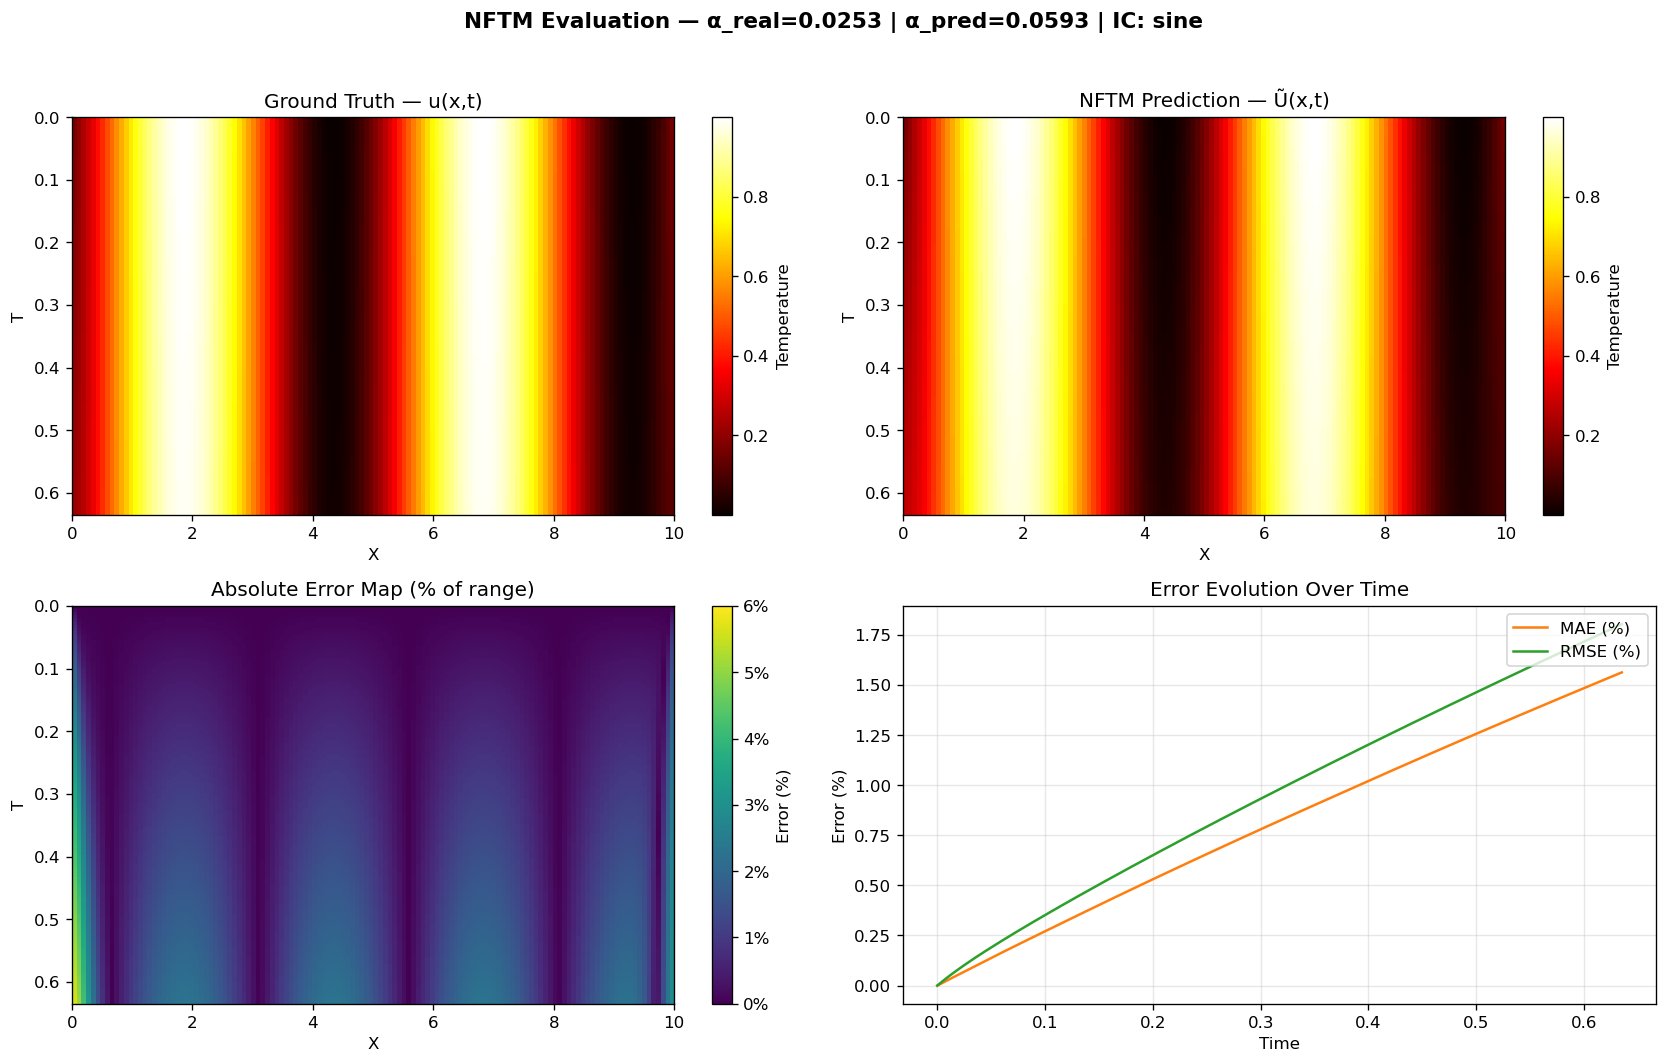

✓ Combined evaluation plot saved to combined_evaluation.png


In [44]:
grid_vis = Grid1D(
    nb_points_x=len(x),
    x_max=float(x.max()),
    nb_points_t=len(t),
    dt=dt_vis
)

fig, axs = plt.subplots(2, 2, figsize=(14, 9), dpi=120)
fig.suptitle(
    f"NFTM Evaluation — α_real={alpha_gt:.4f} | α_pred={alpha_pred:.4f} | IC: {tag}",
    fontsize=13, fontweight="bold"
)

# --- 1. Ground truth ---
im0 = axs[0, 0].imshow(
    U_np,
    extent=[grid_vis.X.min(), grid_vis.X.max(), grid_vis.T.max(), grid_vis.T.min()],
    cmap='hot',
    interpolation='nearest',
    aspect='auto',
    origin='upper'
)
axs[0, 0].set_title("Ground Truth — u(x,t)")
axs[0, 0].set_xlabel("X")
axs[0, 0].set_ylabel("T")
fig.colorbar(im0, ax=axs[0, 0], label="Temperature")

# --- 2. NFTM prediction ---
im1 = axs[0, 1].imshow(
    pred,
    extent=[grid_vis.X.min(), grid_vis.X.max(), grid_vis.T.max(), grid_vis.T.min()],
    cmap='hot',
    interpolation='nearest',
    aspect='auto',
    origin='upper'
)
axs[0, 1].set_title("NFTM Prediction — Ũ(x,t)")
axs[0, 1].set_xlabel("X")
axs[0, 1].set_ylabel("T")
fig.colorbar(im1, ax=axs[0, 1], label="Temperature")

# --- 3. Error map (%)
vmin, vmax = error.min(), error.max()
# Étend légèrement la plage pour éviter que vmax soit coupé
vmin = 0
vmax = np.ceil(vmax * 1.05)

im2 = axs[1, 0].imshow(
    error,
    extent=[grid_vis.X.min(), grid_vis.X.max(), grid_vis.T.max(), grid_vis.T.min()],
    cmap='viridis',
    interpolation='nearest',
    aspect='auto',
    origin='upper',
    vmin=vmin,
    vmax=vmax
)
axs[1, 0].set_title("Absolute Error Map (% of range)")
axs[1, 0].set_xlabel("X")
axs[1, 0].set_ylabel("T")

# --- Colorbar avec ticks en % ---
cbar2 = fig.colorbar(im2, ax=axs[1, 0], label="Error (%)")

# Choisit automatiquement le bon format d'affichage
ticks = cbar2.get_ticks()
if vmax <= 1:
    cbar2.set_ticklabels([f"{t:.1f}%" for t in ticks])  # 1 décimale si petite erreur
else:
    cbar2.set_ticklabels([f"{t:.0f}%" for t in ticks])  # entiers sinon



# --- 4. Error over time ---
axs[1, 1].plot(t, mae_time,  label="MAE (%)",  color="C1", linewidth=1.5)
axs[1, 1].plot(t, rmse_time, label="RMSE (%)", color="C2", linewidth=1.5)
axs[1, 1].set_xlabel("Time")
axs[1, 1].set_ylabel("Error (%)")
axs[1, 1].set_title("Error Evolution Over Time")
axs[1, 1].grid(alpha=0.3)
axs[1, 1].legend(loc="upper right")

plt.tight_layout(rect=[0, 0, 1, 0.96])  # pour éviter le chevauchement avec le titre
out_path = "combined_evaluation.png"
plt.savefig(out_path, bbox_inches="tight")
plt.show()

print(f"✓ Combined evaluation plot saved to {out_path}")